<a href="https://colab.research.google.com/github/julianaquin/precipitation-by-months-RNN/blob/main/DL_RNN_Recurrent_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import TimeSeriesSplit

In [2]:
from google.colab import files
filename = files.upload()

Saving precipitation.csv to precipitation.csv


In [3]:
 df = pd.read_csv("precipitation.csv", sep="\t", engine="python", on_bad_lines="skip")

In [4]:
df.head(12)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1965,0.029,0.069,0.000,21.667,17.859,102.111,606.071,402.521,69.511,5.249,16.232,22.075
1,1966,0.905,0.000,0.000,2.981,63.008,94.088,481.942,59.386,150.624,1.308,41.214,4.132
2,1967,0.248,3.390,1.320,13.482,11.116,251.314,780.006,181.069,183.757,50.404,8.393,37.685
3,1968,0.318,3.035,1.704,23.307,7.441,179.872,379.354,171.979,219.884,73.997,23.326,2.020
4,1969,0.248,2.524,0.334,4.569,6.213,393.682,678.354,397.335,205.413,24.014,24.385,1.951
5,1970,0.070,0.000,0.001,16.218,68.036,300.546,330.502,283.476,158.640,115.758,0.260,0.000
6,1971,0.000,0.000,0.000,0.812,57.691,297.187,122.195,372.693,286.056,39.424,0.554,0.000
7,1972,0.000,0.029,0.000,5.982,19.101,132.413,338.484,68.741,120.415,1.078,24.089,0.143
8,1973,0.000,2.969,0.234,3.925,14.978,304.484,696.024,256.932,183.206,101.805,5.516,0.000
9,1974,0.000,0.000,6.427,16.864,51.209,148.697,405.359,319.651,288.533,188.876,0.260,0.000


In [5]:
#With this code I get rid of the column year
df.set_index('Year', inplace=True)

Text(0.5, 1.0, 'Month vs Precipitation across all years')

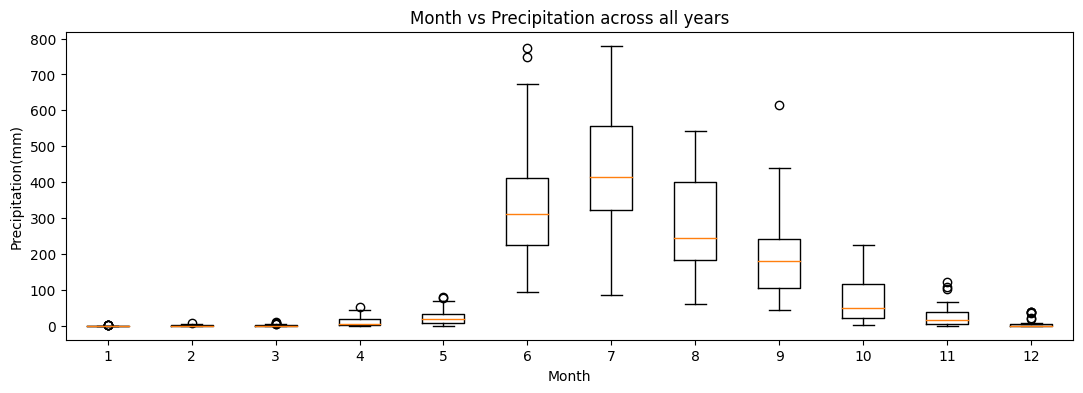

In [6]:
plt.figure(figsize=(13,4))
plt.boxplot(df)
plt.xlabel('Month')
plt.ylabel('Precipitation(mm)')
plt.title('Month vs Precipitation across all years')

In [7]:
#with this code I'm converting the data to numpy and then flattening it to convert it to series
data = df.to_numpy().ravel()

In [8]:
#preparing X and Y
input_with = 24
offset = 0

X = [data[i:i+input_with] for i in range(len(data)-input_with)]
X = np.array(X)

y = [data[i+input_with+offset] for i in range(len(data)-input_with)]
y = np.array(y)

In [9]:
X.shape, y.shape

((432, 24), (432,))

In [10]:
#I design a seq model with input layers, then normalize them, then add lstm layers with return sequences false
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(None,1)),
    tf.keras.layers.BatchNormalization(synchronized=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Dense(units=1)
])

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, None, 1)           4         
 Normalization)                                                  
                                                                 
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4389 (17.14 KB)
Trainable params: 4387 (17.14 KB)
Non-trainable params: 2 (8.00 Byte)
_________________________________________________________________


In [11]:
#Here I compile the model with MSLE because it's a regression problem, then I add a timeseriessplit to X,
#and pass this into the fit parameters, then append all of them to a list
lstm_model.compile(loss='MSLE', optimizer='Adam')
histories=[]
ts = TimeSeriesSplit(n_splits=5, test_size=2)
for i, (train_index, validation_index) in enumerate(ts.split(X)):
  x_train = X[train_index]
  x_val =  X[validation_index]
  y_train = y[train_index]
  y_val = y[validation_index]

  history = lstm_model.fit(x_train,y_train, epochs=100, validation_data=(x_val,y_val))
  histories.append(history)

Epoch 1/100
14/14 [==============================] - 9s 119ms/step - loss: 13.8509 - val_loss: 7.1598
Epoch 2/100
14/14 [==============================] - 0s 33ms/step - loss: 12.6071 - val_loss: 5.9138
Epoch 3/100
14/14 [==============================] - 0s 34ms/step - loss: 9.0313 - val_loss: 3.7024
Epoch 4/100
14/14 [==============================] - 0s 31ms/step - loss: 6.6854 - val_loss: 3.4339
Epoch 5/100
14/14 [==============================] - 0s 30ms/step - loss: 6.2585 - val_loss: 3.3783
Epoch 6/100
14/14 [==============================] - 0s 29ms/step - loss: 6.0176 - val_loss: 3.3621
Epoch 7/100
14/14 [==============================] - 0s 26ms/step - loss: 5.8885 - val_loss: 3.3606
Epoch 8/100
14/14 [==============================] - 0s 26ms/step - loss: 5.7971 - val_loss: 3.3650
Epoch 9/100
14/14 [==============================] - 0s 24ms/step - loss: 5.7309 - val_loss: 3.3726
Epoch 10/100
14/14 [==============================] - 0s 24ms/step - loss: 5.6792 - val_loss: 3.3

In [12]:
#Here I calculate the average of the losses since they were divided in 5 categories
losses = [hist.history['loss'] for hist in histories]
average_eploss= np.mean(losses, axis=0)

val_losses = [hist.history['val_loss'] for hist in histories]
average_ep_valoss= np.mean(val_losses, axis=0)

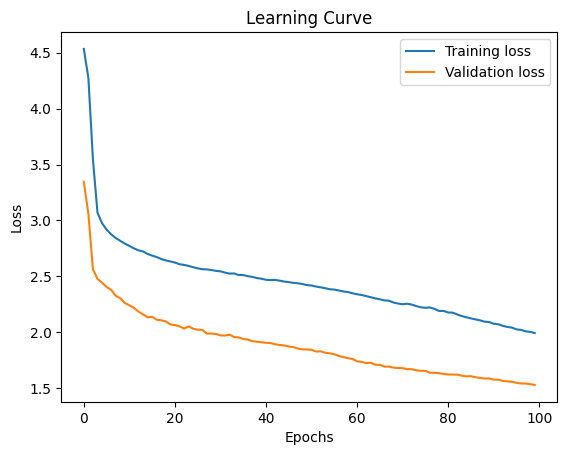

In [13]:
plt.plot(average_eploss, label= "Training loss")
plt.plot(average_ep_valoss, label= "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(["Training loss", "Validation loss"])